Pierre-Elliott THIBOUD  
Julien PERIER-CAMBY  

# IBI - TP1
## Partie 1

In [56]:
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy as np # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data
from tqdm import tqdm_notebook as tqdm

#np.seterr(all='call')

In [6]:
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = np.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image.reshape((28,28)),interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()

In [7]:
LOGGING = False
def printf(*vals):
    if LOGGING:
        print(*vals)

### Chargement des données

In [8]:
TRAIN_BATCH_SIZE = 1

data = pickle.load(gzip.open('mnist.pkl.gz'),encoding='latin1')

train_data = torch.Tensor(data[0][0])
# labels de la base d'apprentissage
train_data_label = torch.Tensor(data[0][1])
# images de la base de test
test_data = torch.Tensor(data[1][0])
# labels de la base de test
test_data_label = torch.Tensor(data[1][1])
# on crée la base de données d'apprentissage (pour torch)
train_dataset = torch.utils.data.TensorDataset(train_data,train_data_label)
# on crée la base de données de test (pour torch)
test_dataset = torch.utils.data.TensorDataset(test_data,test_data_label)
# on crée le lecteur de la base de données d'apprentissage (pour torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
# on crée le lecteur de la base de données de test (pour torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

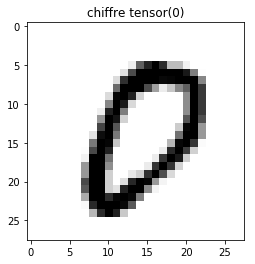

In [9]:
affichage(train_data[0], train_data_label[0])

In [36]:
def initWeightsDefault(input_dim, output_dim):
    return np.random.normal(loc=0.0,scale=1.0,size=(output_dim,input_dim+1))

class Perceptron:
    def __init__(self, input_dim, output_dim, learning_rate, initWeights=initWeightsDefault):
        self.weights = initWeights(input_dim, output_dim)
        self.learning_rate = learning_rate
        self.output_dim = output_dim
        self.input_dim = input_dim

    def forward(self, x):
        # Rajoute le biais
        x = np.append(x.flatten(),1)
        return np.dot(self.weights, x)
    
    def backward(self, x, y ,t):
        error = np.array(t) - y
        self.backward_w_error(np.array(x).flatten(), error)

    # Séparation du calcul de l'erreur et de la rétro-propagation pour réutiliser le Perceptron dans le MLP
    def backward_w_error(self, x, error):
        # Rajoute le biais
        x = np.append(x, 1)
        
        delta = error.reshape(self.output_dim,1).dot(x.reshape(1,self.input_dim+1)) * self.learning_rate
        
        # Mise à jour des poids
        self.weights += delta

In [11]:
# Pour étudier la modification des poids et des différents paramètres lors du développement
def test_training(model):
    for (idx,(image,label)) in enumerate(train_loader):
        if idx > 0:
            break
        
        print("Test training - Forward")
        y = model.forward(image)
        print("Test training - Backward")
        model.backward(image, y, label)

In [12]:
def training(model, epochs, show_progress=False):
    if show_progress:
        for epoch in tqdm(range(epochs)):
            for (idx,(image,label)) in enumerate(train_loader):
                # on demande les prochaines données de la base
                y = model.forward(image)
                model.backward(image, y, label)
    else:
        for epoch in range(epochs):
            for (idx,(image,label)) in enumerate(train_loader):
                # on demande les prochaines données de la base
                y = model.forward(image)
                model.backward(image, y, label)

In [13]:
def test(model, print_accuracy=False, show_progress=False):
    true_positives = 0
    if show_progress:
        for (idx,(image,label)) in enumerate(tqdm(test_loader)):
            if np.argmax(label.numpy()) == np.argmax(model.forward(image)):
                true_positives += 1
    else:
        for (idx,(image,label)) in enumerate(test_loader):
            if np.argmax(label.numpy()) == np.argmax(model.forward(image)):
                true_positives += 1
            
    accuracy = true_positives/len(test_loader)
    if print_accuracy:
        print("Accuracy: ", accuracy)
    return accuracy

### Paramètres

In [14]:
input_dim = 784
nb_class = 10

learning_rate = 0.009

### Perceptron - Test simple

In [89]:
model = Perceptron(input_dim, nb_class, learning_rate)

training(model, 3, show_progress=True)

test(model, print_accuracy=True)

Accuracy:  0.7052857142857143


0.7052857142857143

### Grid search

In [45]:
def plotAccuracy(accuracies, learning_rates, nb_epochs, title=""):
    x_axis = range(1, nb_epochs+1)
    for idx,lr in enumerate(learning_rates):
        plt.plot(x_axis, accuracies[idx], label=f"lr-{lr}")
    plt.legend(loc=2)
    plt.xlabel('Pas de temps (epochs)')
    plt.ylabel('Accuracy (%)')
    plt.title(title)
    plt.show()

In [64]:
def grid_search(learning_rates, nb_epochs=10, show_progress=False, print_accuracy=False, initModel=Perceptron, initWeights=initWeightsDefault):
    i = 0
    accuracies = []
    for lr in learning_rates:
        #print("------------------\nLearning rate :", lr)
        model = initModel(input_dim, nb_class, lr, initWeights=initWeightsDefault)
        print(f"Model {i} created")
        i+=1
        accuracy = []

        for k in range(1,nb_epochs+1):
            training(model, 1, show_progress=show_progress)
            #print("Epoch", k, ": ", end='')
            accu = test(model, print_accuracy=False, show_progress=show_progress)
            accuracy.append(accu)
        accuracies.append(accuracy)
    return accuracies

#### Fonctions d'initialisation des poids

In [37]:
def initUniform(low=0, high=1):
    return lambda input_dim, output_dim: np.random.uniform(low, high, size=(output_dim,input_dim+1))

def initNormal(loc=0, scale=1):
    return lambda input_dim, output_dim: np.random.normal(loc, scale, size=(output_dim,input_dim+1))

In [43]:
learning_rates = (1e-3, 5e-3, 1e-2, 5e-2)

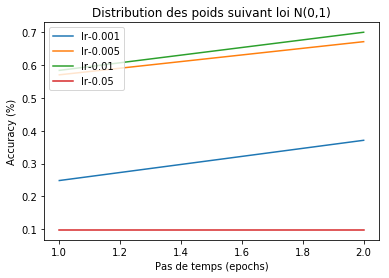

In [47]:
nb_epochs = 2
accuracies = grid_search(learning_rates, nb_epochs)
plotAccuracy(accuracies, learning_rates, nb_epochs, title="Distribution des poids suivant loi N(0,1)")

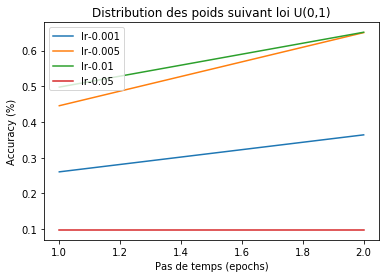

In [46]:
nb_epochs = 2
accuracies = grid_search(learning_rates, nb_epochs, initWeights=initUniform())
plotAccuracy(accuracies, learning_rates, nb_epochs, title="Distribution des poids suivant loi U(0,1)")

## Partie 2 - Shallow Nerwork

In [48]:
class MLP:
    def __init__(self, input_dim, nb_neurons, output_dim, learning_rate, initWeights=initWeightsDefault):
        self.hidden_layer = Perceptron(input_dim, nb_neurons, learning_rate, initWeights=initWeights)
        self.output_layer = Perceptron(nb_neurons, output_dim, learning_rate, initWeights=initWeights)
        self.hidden_output = None
        self.nb_neurons = nb_neurons
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        
    def forward(self, x):
        hidden_layer_output = self.hidden_layer.forward(x)
        self.hidden_output = 1/(1 + np.exp(-1*hidden_layer_output))
        return self.output_layer.forward(self.hidden_output)
    
    def backward(self, x, y ,t):
        output_error = np.array(t) - y
        weights = self.output_layer.weights[:,:-1]
        summ = output_error.dot(weights)
        hidden_error_1 = (1-self.hidden_output)
        hidden_error_2 = hidden_error_1 * self.hidden_output
        hidden_error = hidden_error_2*summ
        
        self.output_layer.backward_w_error(self.hidden_output, output_error)
        self.hidden_layer.backward_w_error(x, hidden_error)

### Paramètres MLP

In [50]:
input_dim = 784
nb_class = 10

learning_rate = 1e-2
nb_neurons = 8

### MLP - Test simple

In [51]:
LOGGING = False
model = MLP(input_dim, nb_neurons, nb_class, learning_rate)

training(model, epochs=3)
test(model, print_accuracy=True)

Accuracy:  0.66


0.66

### Grid search

In [54]:
def initModelFunction(nb_neurons):
    def initModel(input_dim, nb_class, lr, initWeights):
        return MLP(input_dim, nb_neurons, nb_class, lr, initWeights=initWeights)
    return initModel

def MLP_grid_search(learning_rates, hidden_layer_sizes, nb_epochs=6, show_progress=False, initModelF=initModelFunction):
    for size in hidden_layer_sizes:
        print("==================\nHidden layer size:", size)
        initModel = initModelF(size)
        accuracies = grid_search(learning_rates, nb_epochs=nb_epochs, show_progress=show_progress, initModel=initModel)
        plotAccuracy(accuracies, learning_rates, nb_epochs, title=f"Distribution des poids suivant loi N(0,1)\n{size} neurones cachés")

In [65]:
lr = (1e-2, 0.05, 0.1, 0.5)
hidden_layer_sizes = (10, 14)
# hidden_layer_sizes = (25, 32)

MLP_grid_search(lr, hidden_layer_sizes, nb_epochs=3)

Hidden layer size: 10
Model 0 created
Model 1 created
Model 2 created
Model 3 created


NameError: python callback specified for underflow (in  multiply) but no function found.

## Partie 3 - Deep Network

In [ ]:
class TPerceptron:
    def __init__(self, input_dim, output_dim, learning_rate):
        self.weights = torch.randn(input_dim + 1, output_dim, requires_grad=True)
        self.learning_rate = learning_rate
        self.output_dim = output_dim
        self.input_dim = input_dim

    def forward(self, x):
        # Return output
        x = torch.from_numpy(np.append(x.flatten(),1))
        return np.dot(self.weights, x)
    
    def backward(self, x, y ,t):
        error = np.array(t) - y
        self.backward_w_error(np.array(x).flatten(), error)

    def backward_w_error(self, x, error):
        # Rajoute le biais
        x = torch.from_numpy(np.append(x, 1))
        
        delta = error.reshape(self.output_dim,1).dot(x.reshape(1,self.input_dim+1)) * self.learning_rate
        
        # Mise à jour des poids
        self.weights += delta